# Chord Recognition


## Setting up Environment
```bash
$ python -m venv chord
$ source chord/bin/activate # for linux
$ ./chord/Scripts/activate # for windows
$ python.exe -m pip install --upgrade pip # upgrade pip
$ pip install -r requirements.txt
```

In [2]:
# Import dependencies
import numpy as np
import matplotlib.pyplot as plt
import scipy
import librosa
import soundfile as sf
import IPython.display as ipd
import pandas as pd

import libfmp.b
import libfmp.c3
import libfmp.c4

In [3]:
# Load all audio files in folder ./resources
audio, fs = sf.read('resources/Tone_C4_Piano.wav')
ipd.Audio(audio, rate=fs)

## Template Based Chord Recognition

In [115]:
def compute_chromagram_from_filename(fn_wav, Fs=22050, N=4096, H=2048, gamma=None, version='STFT', norm='2'):
    """Compute chromagram for WAV file specified by filename

    Notebook: C5/C5S2_ChordRec_Templates.ipynb

    Args:
        fn_wav (str): Filenname of WAV
        Fs (scalar): Sampling rate (Default value = 22050)
        N (int): Window size (Default value = 4096)
        H (int): Hop size (Default value = 2048)
        gamma (float): Constant for logarithmic compression (Default value = None)
        version (str): Technique used for front-end decomposition ('STFT', 'IIS', 'CQT') (Default value = 'STFT')
        norm (str): If not 'None', chroma vectors are normalized by norm as specified ('1', '2', 'max')
            (Default value = '2')

    Returns:
        X (np.ndarray): Chromagram
        Fs_X (scalar): Feature reate of chromagram
        x (np.ndarray): Audio signal
        Fs (scalar): Sampling rate of audio signal
        x_dur (float): Duration (seconds) of audio signal
    """
    x, Fs = librosa.load(fn_wav, sr=Fs)
    x_dur = x.shape[0] / Fs
    if version == 'STFT':
        # Compute chroma features with STFT
        X = librosa.stft(x, n_fft=N, hop_length=H, pad_mode='constant', center=True)
        if gamma is not None:
            X = np.log(1 + gamma * np.abs(X) ** 2)
        else:
            X = np.abs(X) ** 2
        X = librosa.feature.chroma_stft(S=X, sr=Fs, tuning=0, norm=None, hop_length=H, n_fft=N)
    if version == 'CQT':
        # Compute chroma features with CQT decomposition
        X = librosa.feature.chroma_cqt(y=x, sr=Fs, hop_length=H, norm=None)
    if version == 'IIR':
        # Compute chroma features with filter bank (using IIR elliptic filter)
        X = librosa.iirt(y=x, sr=Fs, win_length=N, hop_length=H, center=True, tuning=0.0)
        if gamma is not None:
            X = np.log(1.0 + gamma * X)
        X = librosa.feature.chroma_cqt(C=X, bins_per_octave=12, n_octaves=7,
                                       fmin=librosa.midi_to_hz(24), norm=None)
    if norm is not None:
        X = libfmp.c3.normalize_feature_sequence(X, norm=norm)
    Fs_X = Fs / H
    return X, Fs_X, x, Fs, x_dur

def plot_chromagram(ax, X, Fs_X, cmap='grey_r', title=''):
    """Plot chromagram and annotation

    Notebook: C5/C5S2_ChordRec_Templates.ipynb

    Args:
        ax: Axes handle
        X: Feature representation
        Fs_X: Feature rate
        ann: Annotations
        color_ann: Color for annotations
        x_dur: Duration of feature representation
        cmap: Color map for imshow (Default value = 'gray_r')
        title: Title for figure (Default value = '')
    """
    libfmp.b.plot_chromagram(X, Fs=Fs_X, ax=ax, chroma_yticks=[0, 4, 7, 11], clim=[0, 1], cmap=cmap, title=title, ylabel='Chroma', colorbar=True)

def get_chord_labels(ext_minor='m', nonchord=False):
    """Generate chord labels for major and minor triads (and possibly nonchord label)

    Notebook: C5/C5S2_ChordRec_Templates.ipynb

    Args:
        ext_minor (str): Extension for minor chords (Default value = 'm')
        nonchord (bool): If "True" then add nonchord label (Default value = False)

    Returns:
        chord_labels (list): List of chord labels
    """
    chroma_labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    chord_labels_maj = chroma_labels
    chord_labels_min = [s + ext_minor for s in chroma_labels]
    chord_labels = chord_labels_maj + chord_labels_min
    if nonchord is True:
        chord_labels = chord_labels + ['N']
    return chord_labels

def generate_chord_templates(nonchord=False):
    """Generate chord templates of major and minor triads (and possibly nonchord)

    Notebook: C5/C5S2_ChordRec_Templates.ipynb

    Args:
        nonchord (bool): If "True" then add nonchord template (Default value = False)

    Returns:
        chord_templates (np.ndarray): Matrix containing chord_templates as columns
    """
    template_cmaj = np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]).T
    template_cmin = np.array([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]).T
    num_chord = 24
    if nonchord:
        num_chord = 25
    chord_templates = np.ones((12, num_chord))
    for shift in range(12):
        chord_templates[:, shift] = np.roll(template_cmaj, shift)
        chord_templates[:, shift+12] = np.roll(template_cmin, shift)
    return chord_templates

def chord_recognition_template(X, norm_sim='1', nonchord=False):
    """Conducts template-based chord recognition
    with major, minor, dim and 7th chords

    Notebook: C5/C5S2_ChordRec_Templates.ipynb

    Args:
        X (np.ndarray): Chromagram
        norm_sim (str): Specifies norm used for normalizing chord similarity matrix (Default value = '1')
        nonchord (bool): If "True" then add nonchord template (Default value = False)

    Returns:
        chord_sim (np.ndarray): Chord similarity matrix
        chord_max (np.ndarray): Binarized chord similarity matrix only containing maximizing chord
    """
    chord_templates = generate_chord_templates(nonchord=nonchord)
    X_norm = libfmp.c3.normalize_feature_sequence(X, norm='2')
    chord_templates_norm = libfmp.c3.normalize_feature_sequence(chord_templates, norm='2')
    chord_sim = np.matmul(chord_templates_norm.T, X_norm)
    if norm_sim is not None:
        chord_sim = libfmp.c3.normalize_feature_sequence(chord_sim, norm=norm_sim)
    # chord_max = (chord_sim == chord_sim.max(axis=0)).astype(int)
    chord_max_index = np.argmax(chord_sim, axis=0)
    chord_max = np.zeros(chord_sim.shape).astype(np.int32)
    for n in range(chord_sim.shape[1]):
        chord_max[chord_max_index[n], n] = 1

    return chord_sim, chord_max


In [116]:
# Extending the chords template to account for dim and 7th chord
def generate_chord_templates_extend():
    """Generate chord templates of major minor and 7th chords (and possibly nonchord)

    Args:
        nonchord (bool): If "True" then add nonchord template (Default value = False)

    Returns:
        chord_templates_extend (np.ndarray): Matrix containing chord_templates as columns
    """
    template_cmaj = np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]).T
    template_cmin = np.array([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]).T
    template_c7th = np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1]).T
    template_cdim = np.array([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0]).T
    num_chord = 48
    chord_templates_extend = np.ones((12, num_chord))
    for shift in range(12):
        chord_templates_extend[:, shift] = np.roll(template_cmaj, shift)
        chord_templates_extend[:, shift+12] = np.roll(template_cmin, shift)
        chord_templates_extend[:, shift+24] = np.roll(template_c7th, shift)
        chord_templates_extend[:, shift+36] = np.roll(template_cdim, shift)
    return chord_templates_extend

def chord_recognition_template_extended(X, norm_sim='1'):
    """Conducts template-based chord recognition
    with major, minor, dim and 7th chords

    Notebook: C5/C5S2_ChordRec_Templates.ipynb

    Args:
        X (np.ndarray): Chromagram
        norm_sim (str): Specifies norm used for normalizing chord similarity matrix (Default value = '1')
        nonchord (bool): If "True" then add nonchord template (Default value = False)

    Returns:
        chord_sim (np.ndarray): Chord similarity matrix
        chord_max (np.ndarray): Binarized chord similarity matrix only containing maximizing chord
    """
    chord_templates = generate_chord_templates_extend()
    X_norm = libfmp.c3.normalize_feature_sequence(X, norm='2')
    chord_templates_norm = libfmp.c3.normalize_feature_sequence(chord_templates, norm='2')
    chord_sim = np.matmul(chord_templates_norm.T, X_norm)
    if norm_sim is not None:
        chord_sim = libfmp.c3.normalize_feature_sequence(chord_sim, norm=norm_sim)
    # chord_max = (chord_sim == chord_sim.max(axis=0)).astype(int)
    chord_max_index = np.argmax(chord_sim, axis=0)
    chord_max = np.zeros(chord_sim.shape).astype(np.int32)
    for n in range(chord_sim.shape[1]):
        chord_max[chord_max_index[n], n] = 1

    return chord_sim, chord_max

def get_chord_labels_extend(ext_minor='m', nonchord=False):
    """Generate chord labels for major and minor triads (and possibly nonchord label)

    Notebook: C5/C5S2_ChordRec_Templates.ipynb

    Args:
        ext_minor (str): Extension for minor chords (Default value = 'm')
        nonchord (bool): If "True" then add nonchord label (Default value = False)

    Returns:
        chord_labels (list): List of chord labels
    """
    chroma_labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    chord_labels_maj = chroma_labels
    chord_labels_min = [s + ext_minor for s in chroma_labels]
    chord_labels_7th = [s + '7' for s in chroma_labels]
    chord_labels_dim = [s + 'dim' for s in chroma_labels]
    chord_labels = chord_labels_maj + chord_labels_min + chord_labels_7th + chord_labels_dim
    if nonchord is True:
        chord_labels = chord_labels + ['N']
    return chord_labels

(12, 48)


(None,
 [<Axes: title={'center': 'Chord Templates'}, xlabel='Chroma', ylabel='Chord'>],
 <matplotlib.image.AxesImage at 0x23eaa1e33d0>)

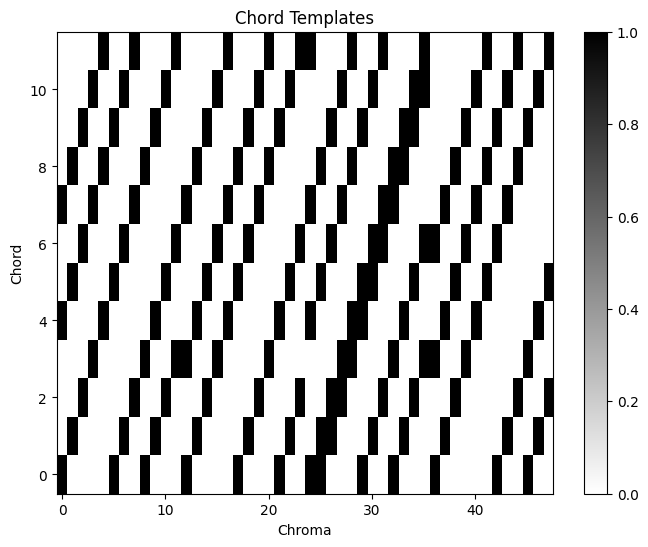

In [117]:
template = generate_chord_templates_extend()
print(template.shape)
# Plot 
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
libfmp.b.plot_matrix(template, ax=[ax], xlabel='Chroma', ylabel='Chord', title='Chord Templates', clim=[0, 1])


In [125]:
# Compute chroma features
# anti_hero_chord_progression.wave: Amaj, Emaj, Bmaj, C#maj
fn_wav = 'resources/piano/antihero.mp3'
ipd.Audio(fn_wav)
x, fs = librosa.load(fn_wav)
print(fs)
print(x.shape)

22050
(582650,)


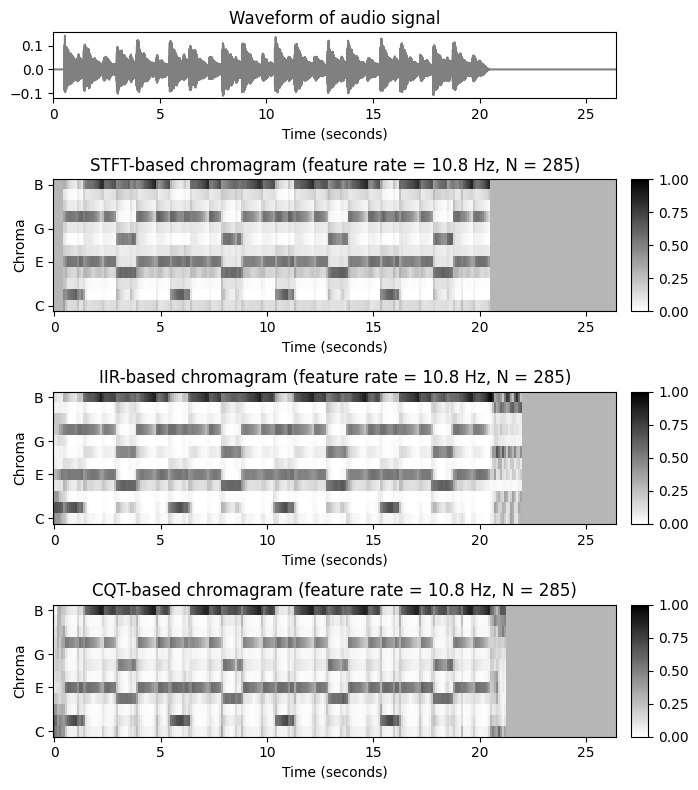

In [126]:
N = 4096
H = 2048
X_STFT, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1, version='STFT')
X_IIR, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=100, version='IIR')
X_CQT, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, version='CQT')

# Plot
cmap = libfmp.b.compressed_gray_cmap(alpha=1, reverse=False)
fig, ax = plt.subplots(4, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                          'height_ratios': [1, 2, 2, 2]}, figsize=(7, 8))
libfmp.b.plot_signal(x, Fs, ax=ax[0,0], title='Waveform of audio signal')

ax[0,1].axis('off')
title = 'STFT-based chromagram (feature rate = %0.1f Hz, N = %d)'%(Fs_X, X_STFT.shape[1])
plot_chromagram([ax[1, 0], ax[1, 1]], X_STFT, Fs_X, title=title)

title = 'IIR-based chromagram (feature rate = %0.1f Hz, N = %d)'%(Fs_X, X_IIR.shape[1])
plot_chromagram([ax[2, 0], ax[2, 1]], X_IIR, Fs_X, title=title)

title = 'CQT-based chromagram (feature rate = %0.1f Hz, N = %d)'%(Fs_X, X_CQT.shape[1])
plot_chromagram([ax[3, 0], ax[3, 1]], X_CQT, Fs_X, title=title)

plt.tight_layout()

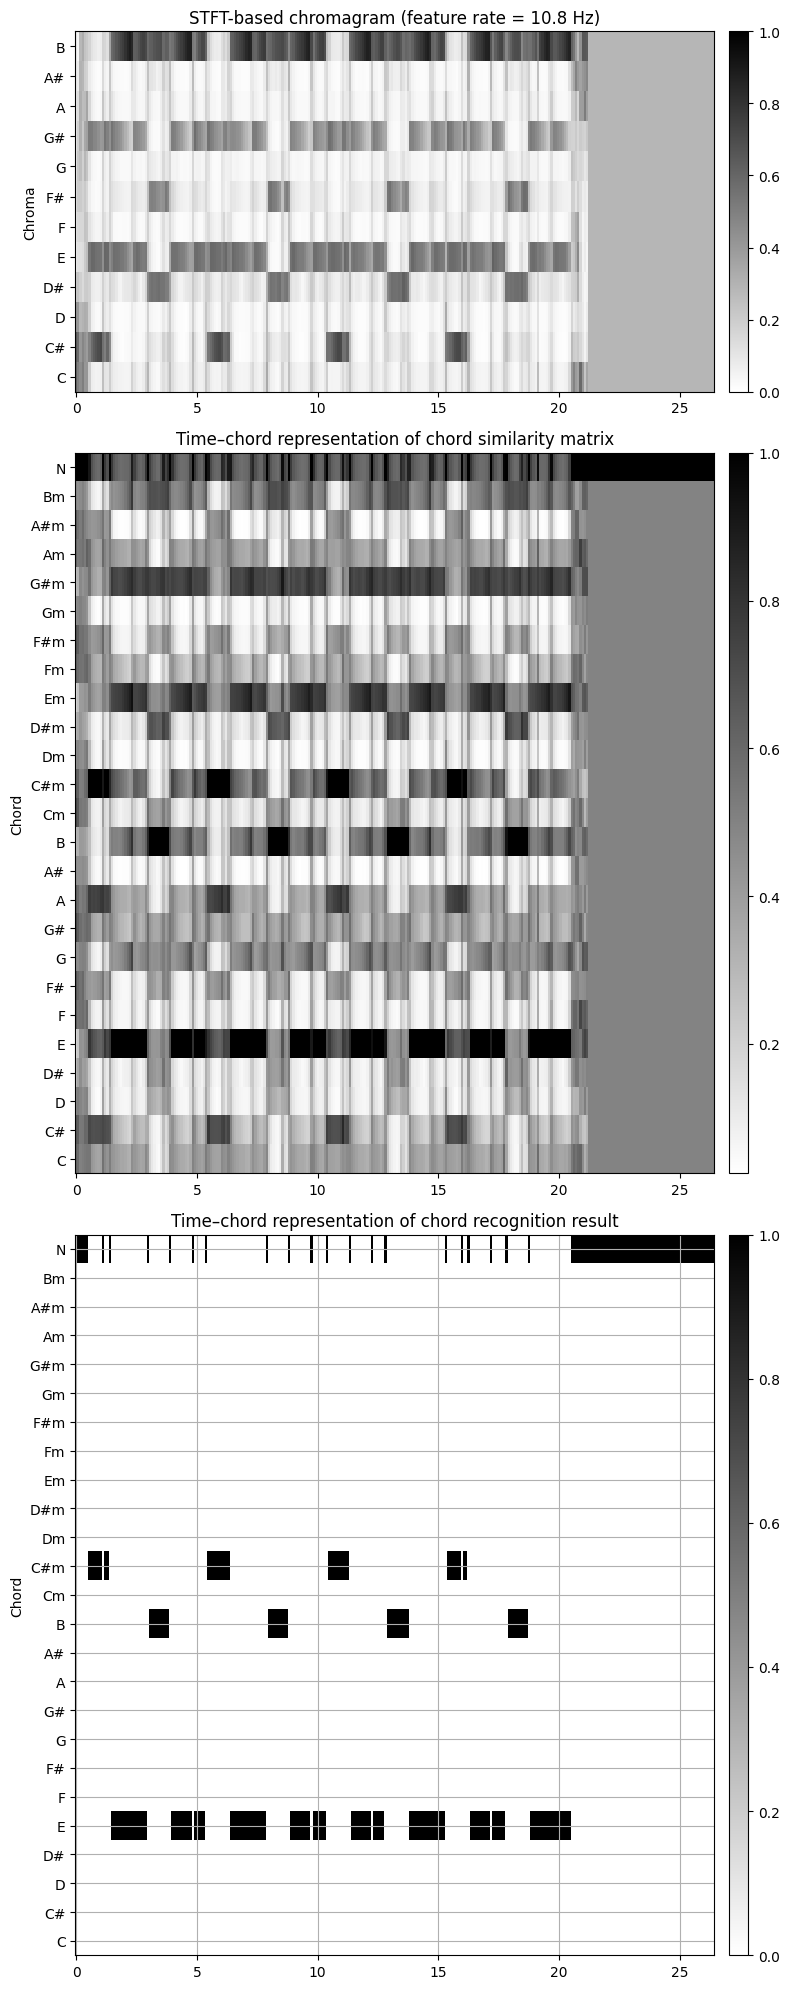

In [127]:
# Chord recognition
X = X_CQT
chord_sim, chord_max = chord_recognition_template(X,nonchord=True, norm_sim='max')
chord_labels = get_chord_labels(nonchord=True)

# Plot
cmap = libfmp.b.compressed_gray_cmap(alpha=1, reverse=False)
fig, ax = plt.subplots(3, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                          'height_ratios': [1.5, 3, 3]}, figsize=(8, 20))
libfmp.b.plot_chromagram(X, ax=[ax[0,0], ax[0,1]], Fs=Fs_X, clim=[0, 1], xlabel='',
                         title='STFT-based chromagram (feature rate = %0.1f Hz)' % (Fs_X))

libfmp.b.plot_matrix(chord_sim, ax=[ax[1, 0], ax[1, 1]], Fs=Fs_X, 
                     title='Time–chord representation of chord similarity matrix',
                     ylabel='Chord', xlabel='')
ax[1, 0].set_yticks(np.arange( len(chord_labels) ))
ax[1, 0].set_yticklabels(chord_labels)

libfmp.b.plot_matrix(chord_max, ax=[ax[2, 0], ax[2, 1]], Fs=Fs_X, 
                     title='Time–chord representation of chord recognition result',
                     ylabel='Chord', xlabel='')
ax[2, 0].set_yticks(np.arange( len(chord_labels) ))
ax[2, 0].set_yticklabels(chord_labels)
ax[2, 0].grid()
plt.tight_layout()
        